# Quora question pairs: training

## Import packages

In [17]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [26]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights_network1.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

## Load the dataset, embedding matrix and word count

In [19]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [20]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [21]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

#layer 1 for question 1 to convert the sequence of vectors into dense representation
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
#We use time distributed layer to formulate the sequential nature of our words in the question
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

#layer 1 for question 2 to convert the sequence of vectors into dense representation
q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
#We use time distributed layer to formulate the sequential nature of our words in the question
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

#Concatenate the representations for question 1 and 2
merged = concatenate([q1,q2])

#dense layer 1
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#final prediction using sigmoid activation
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 25, 300)      28947900    input_9[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 300)      28947900    input_10[0][0]                   
__________________________________________________________________________________________________
time_distr

## Train the model, checkpointing weights with best validation accuracy

In [24]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()

#callback to store the best weights
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-03-28 01:08:24.731394
Train on 327472 samples, validate on 36386 samples
Epoch 1/25
 - 193s - loss: 0.4246 - acc: 0.7999 - val_loss: 0.4477 - val_acc: 0.7865
Epoch 2/25
 - 209s - loss: 0.4075 - acc: 0.8106 - val_loss: 0.4368 - val_acc: 0.7887
Epoch 3/25
 - 215s - loss: 0.3939 - acc: 0.8192 - val_loss: 0.4236 - val_acc: 0.7962
Epoch 4/25
 - 208s - loss: 0.3813 - acc: 0.8259 - val_loss: 0.4166 - val_acc: 0.8009
Epoch 5/25
 - 216s - loss: 0.3686 - acc: 0.8333 - val_loss: 0.4247 - val_acc: 0.7940
Epoch 6/25
 - 214s - loss: 0.3584 - acc: 0.8389 - val_loss: 0.4220 - val_acc: 0.7993
Epoch 7/25
 - 215s - loss: 0.3493 - acc: 0.8441 - val_loss: 0.4250 - val_acc: 0.7999
Epoch 8/25
 - 213s - loss: 0.3423 - acc: 0.8481 - val_loss: 0.4153 - val_acc: 0.8042
Epoch 9/25
 - 209s - loss: 0.3339 - acc: 0.8522 - val_loss: 0.4550 - val_acc: 0.7718
Epoch 10/25
 - 212s - loss: 0.3286 - acc: 0.8557 - val_loss: 0.4155 - val_acc: 0.8055
Epoch 11/25
 - 206s - loss: 0.3219 - acc: 0.8591 -

## Plot training and validation accuracy

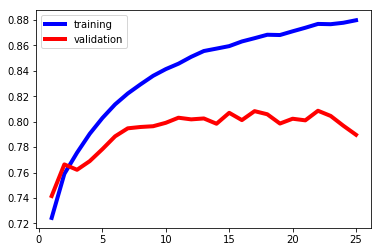

In [24]:
import matplotlib.pyplot as plt
# Data
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']}) 
# multiple line plot
ax= plt.plot( 'epoch', 'training', data=acc,markersize=12, color='blue', linewidth=4)
ax= plt.plot( 'epoch', 'validation', data=acc,markersize=12, color='red', linewidth=4)

plt.legend()

## Print best validation accuracy and epoch

In [12]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 22 = 0.8086


## Evaluate the model with best validation accuracy on the test partition

In [3]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

## Testing individual sentences

### Use this section as a server for the Web Application

In [42]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [36]:
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights_network1.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']
    
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))

with open('word_index.pickle', 'rb') as handle:
    word_indices = pickle.load(handle)

In [37]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

#layer 1 for question 1 to convert the sequence of vectors into dense representation
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
#We use time distributed layer to formulate the sequential nature of our words in the question
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

#layer 1 for question 2 to convert the sequence of vectors into dense representation
q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
#We use time distributed layer to formulate the sequential nature of our words in the question
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

#Concatenate the representations for question 1 and 2
merged = concatenate([q1,q2])

#dense layer 1
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#final prediction using sigmoid activation
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4180, accuracy = 0.8118


In [38]:
def word2vec(question):
    word_seq = keras.preprocessing.text.text_to_word_sequence(question)
    
    vec_sequence = [word_indices[w] for w in word_seq]
    
    vec_sequence = pad_sequences([vec_sequence], maxlen= 25)
    return vec_sequence
 

In [45]:
question1 = 'Hi the basketball league is fraud?'
question2 = 'Hi what era is this?'

model.load_weights(MODEL_WEIGHTS_FILE)
predictions = model.predict([word2vec(question1), word2vec(question2)], verbose=0)

predictions

array([[0.00376096]], dtype=float32)